In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# !mkdir pos_tagger

In [ ]:
cd pos_tagger

/content/drive/My Drive/pos_tagger


In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz -O - | gunzip | cut -f1,2 -d" " > pos.train.txt

--2021-05-20 03:10:12--  http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz [following]
--2021-05-20 03:10:13--  https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611540 (597K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 597.21K  --.-KB/s    in 0.07s   

2021-05-20 03:10:13 (8.06 MB/s) - written to stdout [611540/611540]



In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz -O - | gunzip | cut -f1,2 -d " " > pos.test.txt

--2021-05-20 03:10:13--  http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz [following]
--2021-05-20 03:10:13--  https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139551 (136K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 136.28K   325KB/s    in 0.4s    

2021-05-20 03:10:14 (325 KB/s) - written to stdout [139551/139551]



In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import nltk
from nltk import word_tokenize
from nltk.classify import MaxentClassifier

import string
import re
import spacy

import pickle
from collections import Counter

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
np.random.seed(20)

In [ ]:
remove_tags = ['.',',','(',')',':','``',"''",'#','$']

In [ ]:
train_file = "pos.train.txt"
test_file = "pos.test.txt"

def create_dataset(filename):
    data = []
    label = []
    with open(filename, 'r') as f:
        x = []
        y = []
        for line in f:
            s = line.split()
            if s == []:
                data.append(" ".join(x))
                label.append(" ".join(y))
                x = []
                y = []
                continue
            x.append(s[0])
            if s[1] in remove_tags:
                y.append("PUN")
            else:
                y.append(s[1])
    return data, label

X_train, y_train_tags = create_dataset(train_file)
X_test, y_test_tags = create_dataset(test_file)

In [ ]:
POS_tags = {}
for line in y_train_tags:
    s = line.split()
    for elem in s:
        if elem not in POS_tags:
            POS_tags[elem] = 1
        else:
            POS_tags[elem] += 1
print(len(POS_tags))
print(POS_tags)

36
{'NN': 30147, 'IN': 22764, 'DT': 18335, 'VBZ': 4648, 'RB': 6607, 'VBN': 4763, 'TO': 5081, 'VB': 6017, 'JJ': 13085, 'NNS': 13619, 'NNP': 19884, 'PUN': 26009, 'CC': 5372, 'POS': 1769, 'VBP': 2868, 'VBG': 3272, 'PRP$': 1881, 'CD': 8315, 'VBD': 6745, 'EX': 206, 'MD': 2167, 'NNPS': 420, 'PRP': 3820, 'JJS': 374, 'WP': 529, 'RBR': 321, 'JJR': 853, 'WDT': 955, 'WRB': 478, 'RBS': 191, 'PDT': 55, 'RP': 83, 'FW': 38, 'WP$': 35, 'SYM': 6, 'UH': 15}


Mean = 23.66678845451224
Max = 78
Min = 1


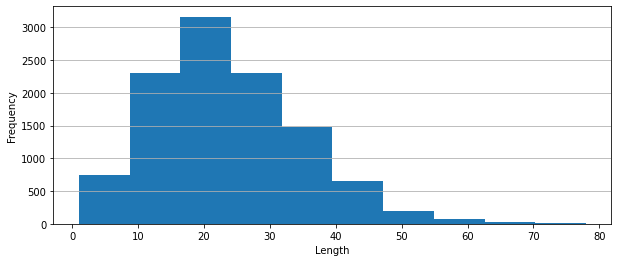

In [ ]:
length = []
for row in X_train:
  length.append(len(row.split()))
for row in X_test:
  length.append(len(row.split()))

mean = sum(length)/len(length)
print(f'''Mean = {mean}
Max = {max(length)}
Min = {min(length)}''')

plt.figure(figsize=(10, 4))
plt.hist(length)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [ ]:
def perform_tokenization(text):
    # return the reviews after performing tokenization
    tokanized_text = []
    for i in range(len(text)):
        s = text[i].split()
        tokanized_text.append(s)
    return tokanized_text 

In [ ]:
def features(sentence, label, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'prev_tag': 'start' if index == 0 else label[index-1]
    }

In [ ]:
def preprocess_data(data, labels=None):
    data = perform_tokenization(data)
    if labels:
        data = [[features(sent, labels[j].split(), i) for i, _ in enumerate(sent)] for j, sent in enumerate(data)]
        labels = [label.split() for label in labels]
    else:
        X = []
        for sent in data:
            feature = []
            temp = ['start' for k in range(len(sent))]
            for i, _ in enumerate(sent):
                feature.append(features(sent, temp, i))
        X.append(feature)
        data = X.copy()
    return data, labels

In [ ]:
features_train, tags_train = preprocess_data(X_train, y_train_tags)
features_test, tags_test = preprocess_data(X_test, y_test_tags)

In [ ]:
print(len(features_train[0]))
print(len(tags_train[0]))
print(features_train[0])
print(tags_train[0])

37
37
[{'word': 'Confidence', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'C', 'prefix-2': 'Co', 'suffix-3': 'nce', 'prev_word': '', 'next_word': 'in', 'has_hyphen': False, 'is_numeric': False, 'prev_tag': 'start'}, {'word': 'in', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'i', 'prefix-2': 'in', 'suffix-3': 'in', 'prev_word': 'Confidence', 'next_word': 'the', 'has_hyphen': False, 'is_numeric': False, 'prev_tag': 'NN'}, {'word': 'the', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 't', 'prefix-2': 'th', 'suffix-3': 'the', 'prev_word': 'in', 'next_word': 'pound', 'has_hyphen': False, 'is_numeric': False, 'prev_tag': 'IN'}, {'word': 'pound', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'p', 'prefix-2'

In [ ]:
tag_vocabulary = list(POS_tags.keys())
print(tag_vocabulary)

['NN', 'IN', 'DT', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'JJ', 'NNS', 'NNP', 'PUN', 'CC', 'POS', 'VBP', 'VBG', 'PRP$', 'CD', 'VBD', 'EX', 'MD', 'NNPS', 'PRP', 'JJS', 'WP', 'RBR', 'JJR', 'WDT', 'WRB', 'RBS', 'PDT', 'RP', 'FW', 'WP$', 'SYM', 'UH']


In [ ]:
train_set = []
for i in range(len(tags_train)):
    for j in range(len(tags_train[i])):
        train_set.append((features_train[i][j], tags_train[i][j]))

test_set = []
for i in range(len(tags_test)):
    for j in range(len(tags_test[i])):
        test_set.append((features_test[i][j], tags_test[i][j]))

In [ ]:
len(train_set)

211727

In [ ]:
maxent_classifier = MaxentClassifier.train(train_set, max_iter=5)

In [ ]:
with open('maxent_classifier.pkl', 'wb') as f:
    pickle.dump(maxent_classifier, f)

In [ ]:
with open('maxent_classifier.pkl', 'rb') as f:
    maxent_classifier = pickle.load(f)

In [ ]:
tags_list = maxent_classifier.labels().copy()
print(tags_list)

['VBP', 'RBS', 'NN', 'UH', 'PDT', 'JJR', 'TO', 'DT', 'VBG', 'MD', 'CC', 'JJ', 'JJS', 'POS', 'WRB', 'WP', 'RBR', 'PRP', 'VBD', 'PRP$', 'VB', 'NNS', 'NNP', 'EX', 'WDT', 'VBZ', 'PUN', 'FW', 'CD', 'SYM', 'NNPS', 'RB', 'VBN', 'WP$', 'RP', 'IN']


In [ ]:
def viterbi(features, model, tags_list):
    sent_len = len(features)
    dp = np.ones((sent_len, len(tags_list)))
    bp = np.ones((sent_len, len(tags_list)))

    for i in range(len(tags_list)):
        features[0]['prev_tag'] = 'start'
        pmf = model.prob_classify(features[0])
        prob = float(pmf.prob(tags_list[i]))
        dp[0,i] = prob

    for i in range(1, dp.shape[0]):
        for j in range(dp.shape[1]):
            temp = []
            for k in range(dp.shape[1]):
                features[i]['prev_tag'] = tags_list[k]
                pmf = model.prob_classify(features[i])
                prob = float(pmf.prob(tags_list[j]))
                mult = dp[i-1,k]*prob
                temp.append(mult)
            dp[i,j] = max(temp)
            bp[i,j] = np.argmax(temp)

    pred_tags = np.zeros(sent_len)
    pred_tags[-1] = np.argmax(dp[-1])
    for i in range(sent_len-2, -1, -1):
        pred_tags[i] = bp[i+1, int(pred_tags[i+1])]

    return [tags_list[int(k)] for k in pred_tags]

In [ ]:
test_features = [elem[0] for elem in test_set]
test_labels = [elem[1] for elem in test_set]

In [ ]:
def test_model(sent_features, ytrue, model):
    pred_tags = []
    labels = []
    for i in range(len(sent_features)):
        if i%5==0:
            print(f"Processing sentence {i+1}...")
        tags = viterbi(sent_features[i], model, tags_list)
        pred_tags += tags
        labels += ytrue[i]
    return pred_tags, labels

In [ ]:
tags, labels = test_model(features_test[:1000], tags_test[:1000], maxent_classifier)

In [ ]:
def accuracy(ypred, ytrue):
    assert len(ypred)==len(ytrue)
    total = len(ytrue)
    correct = 0
    for pred, true in zip(ypred, ytrue):
        if pred == true:
            correct += 1
    print(correct, total)
    return float(correct) / float(total)

In [ ]:
acc = accuracy(tags, labels)
print(acc)

In [ ]:
def tag_sentence(sent, model, tags_list):
    data, _ = preprocess_data(sent)
    print(data[0])
    print(len(data[0]))
    tags = viterbi(data[0], model, tags_list)
    print(len(tags))
    return tags

In [ ]:
s = ["Hello , my name is Shyam and I am a student at EPFL university in Switzerland ."]

tag_sentence(s, maxent_classifier, tags_list)

[{'word': 'Hello', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'H', 'prefix-2': 'He', 'suffix-3': 'llo', 'prev_word': '', 'next_word': ',', 'has_hyphen': False, 'is_numeric': False, 'prev_tag': 'start'}, {'word': ',', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'is_all_caps': True, 'is_all_lower': True, 'prefix-1': ',', 'prefix-2': ',', 'suffix-3': ',', 'prev_word': 'Hello', 'next_word': 'my', 'has_hyphen': False, 'is_numeric': False, 'prev_tag': 'start'}, {'word': 'my', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'm', 'prefix-2': 'my', 'suffix-3': 'my', 'prev_word': ',', 'next_word': 'name', 'has_hyphen': False, 'is_numeric': False, 'prev_tag': 'start'}, {'word': 'name', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'n', 'prefix-2': 'na', 'suffix-3': 'a

['NNP',
 'PUN',
 'DT',
 'NN',
 'VBZ',
 'NNP',
 'CC',
 'PRP',
 'VBP',
 'DT',
 'NN',
 'IN',
 'NNP',
 'NN',
 'IN',
 'NNP',
 'PUN']